# Lab 1: Independent Component Analysis

### Machine Learning 2 (2017/2018)

* The lab exercises should be made in groups of two people.
* The deadline is Thursday, April 19, 23:59.
* Assignment should be submitted through BlackBoard! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [1]:
%pylab inline
import sys
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed"

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X, title="Signals"):
    """
    Plot the signals contained in the rows of X.
    """
    figure()
    
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)

Populating the interactive namespace from numpy and matplotlib


In [2]:

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X, title="Signals"):
    """
    Plot the signals contained in the rows of X.
    """
    figure()
    
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)

The following code generates some toy data to work with.

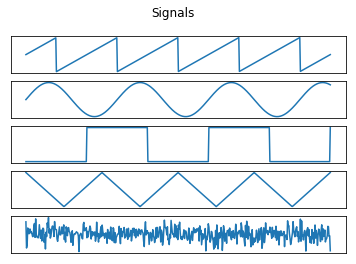

In [3]:
# Generate data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
plot_signals(S)

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)' that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$.

In [4]:
### 1.1 Make mixtures
def make_mixtures(S, A):
    '''Creates mixtures of the sources with the mixing
    matrix A.
    
    Args:
        S (numpy.array): SxT matrix containing S signals
            for T time steps.
        A (numpy.array): MxS nonsingular mixing matrix.
           
    Returns:
        (np.array) MxT matrix containing M measurements
        mixed for T time steps from the sources.
    '''
    return A@S

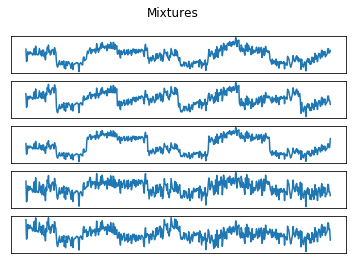

In [5]:
### Test your function
np.random.seed(42)
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
plot_signals(X, "Mixtures")

assert X.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.2 Histogram (5 points)
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the `np.histogram()` (followed by `plot`) or `plt.hist()` function. 

Plot histograms of the sources and the measurements.

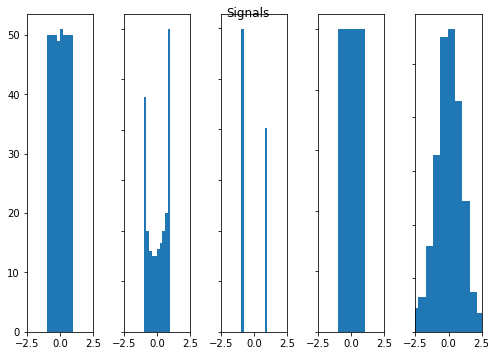

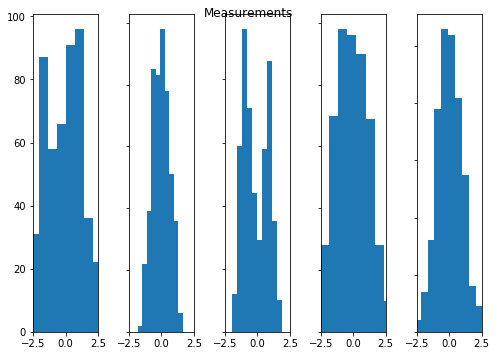

In [6]:
### 1.2 Histogram
def plot_histograms(
        X, title='Signals', fig=plt.figure(figsize=(7, 5)), xlim=[-2.5, 2.5]):
    '''Plot the histograms for each row in a matrix.
    
    Args:
        X (np.array): Matrix for which a histogram
            is plotted of each row.
        title (str): Title
        fig (matplotlib.pyplot.figure, optional):
            Figure for plotting.
        xlim (list of floats): Limits of the x-axes.
    '''
    fig.clf()
    rows, cols = shape(X)
    for i, row in enumerate(X):
        ax = fig.add_subplot(1, rows, i+1)
        plt.hist(row)
        if i > 0:
            plt.setp(ax.get_yticklabels(), visible=False)
        ax.set_xlim(xlim)
    plt.tight_layout()
    plt.suptitle(title)

plot_histograms(S, title='Signals')
fig = plt.figure(3, figsize=(7, 5))
plot_histograms(X, title='Measurements', fig=fig)

Which of these distributions (sources or measurements) tend to look more like Gaussians? Can you think of an explanation for this phenomenon? Why is this important for ICA?

The Gaussian noise source is obviously expected to create a distribution which tends to look like a Gaussian. The sawtooth and the triangle are expected to look uniform. The block wave is degenerate. And the sine wave like a half-pipe. The measurements will look like a combination of these, depending on the values in the mixing matrix $A$. With ICA we will (try to) extract the sources from the measurements. A Gaussian is rotation invariant, ICA will not work if multiple sources are rotation invariant, as explained in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms".

### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$. For each of the following activation functions, *derive* the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$ 
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

Give your answer without the normalizing constant, so an answer of the form $p(a) \propto \verb+[answer]+$ is ok.

\begin{align}
    p_0(a) & \propto \frac{1}{cosh(a)} \\
    p_1(a) & \propto cosh(a) \exp\left[-\frac{a^2}{2}\right] \\
    p_2(a) & \propto \exp\left[-\frac{a^4}{4}\right] \\
    p_3(a) & \propto \frac{1}{(a^2 +5)^3} 
\end{align}

In [7]:
def phi_0(a):
    return -np.tanh(a)

def p_0(a):
    return 1/np.cosh(a)

In [8]:
def phi_1(a):
    return -a + np.tanh(a)

def p_1(a):
    return np.cosh(a) * np.exp(-0.5*(a**2))

In [9]:
def phi_2(a):
    return -a**3

def p_2(a):
    return np.exp(-0.25*(a**4))

In [10]:
def phi_3(a):
    return -6*a / (a**2 + 5)

def p_3(a):
    return (a**2 + 5)**(-3)

In [11]:
activation_functions = [phi_0, phi_1, phi_2, phi_3]
priors = [p_0, p_1, p_2, p_3]

a = np.linspace(-5, 5, 1000)
for prior in priors:
    assert prior(a).shape == (1000, ), "Wrong output shape"


In [12]:
a = np.linspace(-5, 5, 10)
for act_f in activation_functions:
    print(act_f(a))

[ 0.9999092   0.99916247  0.99229794  0.93110961  0.5046724  -0.5046724
 -0.93110961 -0.99229794 -0.99916247 -0.9999092 ]
[ 4.0000908   2.88972642  1.78547984  0.73555706  0.05088316 -0.05088316
 -0.73555706 -1.78547984 -2.88972642 -4.0000908 ]
[ 125.           58.81344307   21.43347051    4.62962963    0.17146776
   -0.17146776   -4.62962963  -21.43347051  -58.81344307 -125.        ]
[ 1.          1.1595092   1.31067961  1.28571429  0.62790698 -0.62790698
 -1.28571429 -1.31067961 -1.1595092  -1.        ]


Plot the activation functions and the corresponding prior distributions, from $a = -5$ to $5$ (hint: use the lists defined in the cell above). Compare the shape of the priors to the histogram you plotted in the last question.

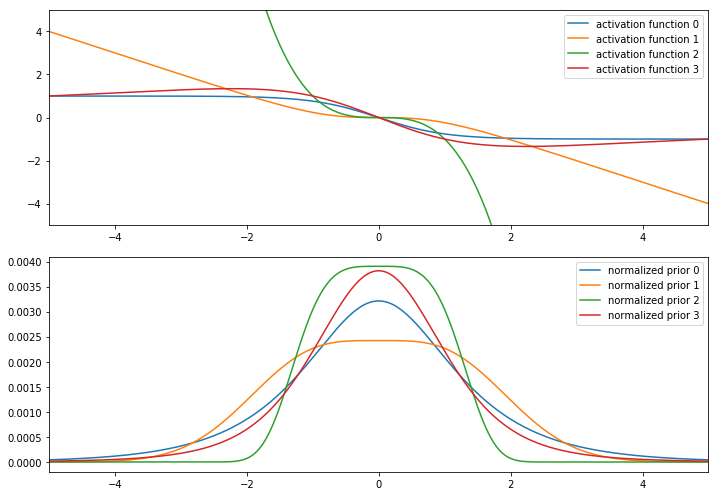

In [60]:
### 1.3 Implicit priors (continued)
def plot_actv_priors(act_fs, priors, r=np.linspace(-5, 5, 1000), 
                     fig=plt.figure(figsize=(10, 7))):
    '''Plot the activation functions with the corresponding priors.
    
    Args:
        act_fs (list of func): The activation functions.
        priors (list of func): The priors.
        r (np.linspace, optional): Range of the plots.
        fig matplotlib.pyplot.figure, optional): Figure for plotting.
    '''
    assert len(act_fs) == len(priors)
    mi, ma = min(r), max(r)
    
    ax1 = fig.add_subplot(2, 1, 1)
    for i, act_f in enumerate(act_fs):
        ax1.plot(r, act_f(r), label='activation function %s' % i)
    ax1.set_xlim([mi, ma])
    ax1.set_ylim([-5, 5])
    plt.legend()
    
    ax2 = fig.add_subplot(2, 1, 2)
    for i, prior in enumerate(priors):
        prior_vals = prior(r)
        ax2.plot(r, prior_vals/sum(prior_vals), label='normalized prior %s' % i)
    ax2.set_xlim([mi, ma])
    plt.legend()
    
    plt.tight_layout()
plot_actv_priors(activation_functions, priors)

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf. Your function should also center the data before whitening.

In [14]:
### 1.4 Whitening
import numpy.matlib
def whiten(X):
    '''Whiten data.
    
    Args:
        X (np.array): The data to be whitened.
        
    Returns:
        (np.array): The whitened data with same dimensions
        as the input.
    '''
    # Zero mean the data
    Xw = (X.T - (mean(X, 1)).T).T
    # Use SVD to perform whitening
    U, _, Vt = np.linalg.svd(Xw, full_matrices=False)
    return np.dot(U, Vt)

In [15]:
### Test your function
Xw = whiten(X)
assert Xw.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.5 Interpret results of whitening (10 points)
Make 3 figures, one for the sources, one for measurements and one for the whitened measurements. In each figure, make $5 \times 5$ subplots with scatter plots for each pair of signals. Each axis represents a signal and each time-instance is plotted as a dot in this space. You can use the `plt.scatter()` function. Describe what you see.

Now compute and visualize the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize each covariance matrix using this code:
```python
# Dummy covariance matrix C;
C = np.eye(5)  
ax = imshow(C, cmap='gray', interpolation='nearest')
```

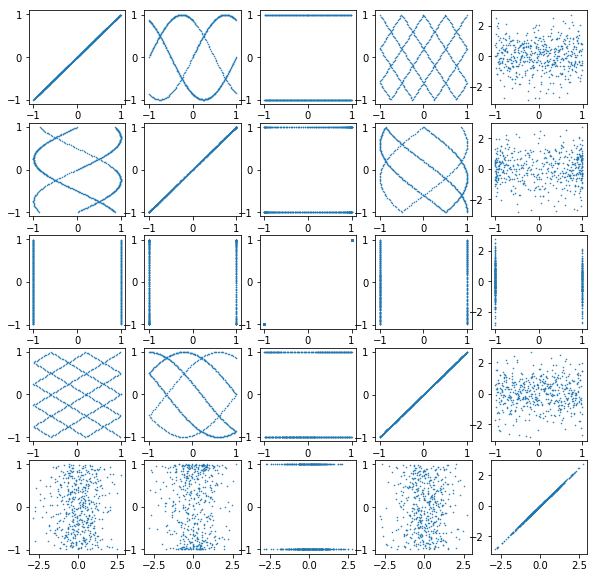

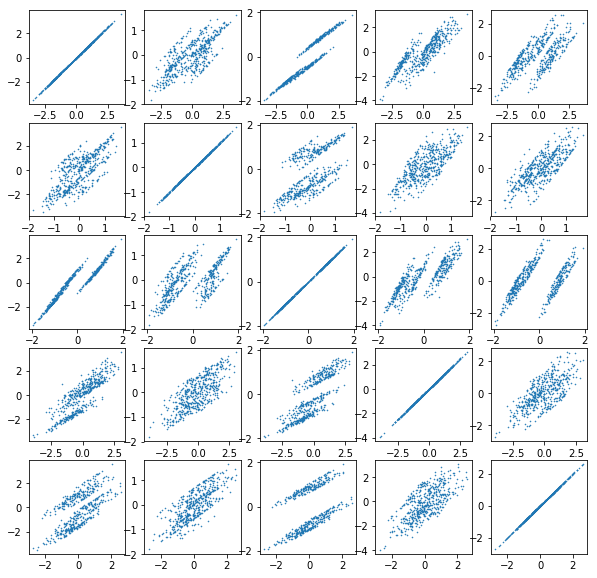

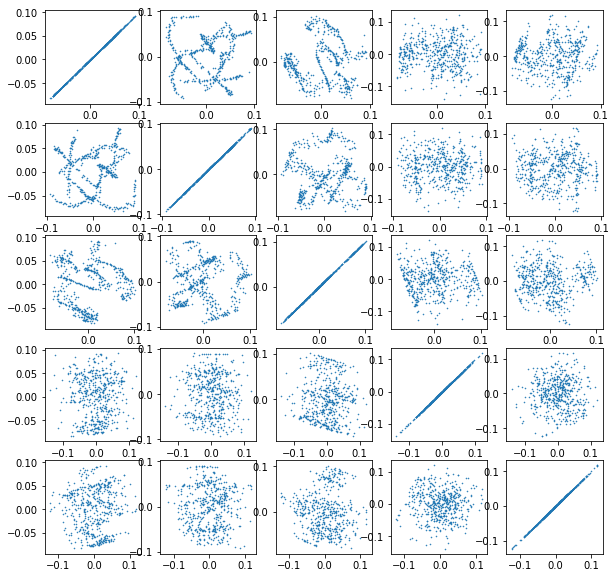

In [61]:
### 1.5 Interpret results of whitening
def plot_signalpairs(X, fig=plt.figure(figsize=(10, 10))):
    '''Plots the signal pairs.
    
    Args:
        X (np.array): Matrix containing the data
            of which the signals pairs are going
            to be plotted.
        fig (matplotlib.pyplot.figure): Figure to plot
            in.
    '''
    for i in range(0,5):
        for j in range(0,5):
            fig.add_subplot(5,5, i*5+j+1)
            x = X[i]
            y = X[j]
            plt.scatter(x,y,0.3)
        
figsize = (10, 10)
fig = plt.figure(1, figsize=figsize)
plot_signalpairs(S, fig=fig)

fig = plt.figure(2, figsize=figsize)
plot_signalpairs(X, fig=fig)

fig = plt.figure(3, figsize=figsize)
plot_signalpairs(Xw, fig=fig)

Are the signals independent after whitening?

No. Whitening first decorrelates the data using the eigenvalue decomposition (or SVD in our case), and uncorrelated implies independence only when the distribution is gaussian. The signals are only partially gaussian; it has non-gaussian components such as a sinewave, sawtooth, etc.

### 1.6 Covariance (5 points)
Explain what a covariant algorithm is. 

A covariant algorithm is a algorithm that gives the same results independent of the units in which quantities are measured. In other words, it is invariant to scale changes or bias; only the shape of the distribution matters.

### 1.7 Independent Component Analysis (25 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Make it efficient, so use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code). Experiment with the learning rate and the initialization of $\mathbf{W}$. Your algorithm should be able to converge (i.e. `np.linalg.norm(grad) < 1e-5`) in within 10000 steps.

In [17]:
### 1.7 Independent Component Analysis
def ICA(X, activation_function, learning_rate=0.1, 
        max_iters=10000, print_every=100000):
    '''Applies Independent Component Analysis.
    
    Args:
        X (np.array): MxT matrix containing the
            measurments.
        activation_function (func): Activation function.
        learning_rate (float, optional): The
            learing rate for updating the weights.
            Defaults to 0.1.
        max_iters (int, optional): Maximum number
            of iterations. Defaults to 10000.
        print_every (int, optional): Print every
            number of iterations. Defaults to 10000.
            
    Returns:
        (np.array) The denoising matrix.
    '''
    # Initializes weights
    num_sources, num_samples = shape(X)
    W = random_nonsingular_matrix(num_sources)
    
    i, grad_norm = 1, np.inf
    while i < max_iters and grad_norm > 1e-5:
        # ICA algorithm
        A = W @ X
        Z = activation_function(A)
        Xn = W.T @ A
        dW = W + (Z @ Xn.T) / num_samples
        
        # norm of grad
        grad_norm = linalg.norm(dW)
        
        # update weights
        W += learning_rate * dW
        
        if not i % print_every:
            print('Iteration %i, Error: %.5f' % (i, grad_norm))
        i += 1
    if i == max_iters:
        print('Not converged.')
    else:
        print('Converged in %i iterations, final weight gradient norm %.5f' % (i, grad_norm))
    return W

In [45]:
# We will test your function so make sure it runs with only X and phi as input, and returns only W
# Also it should converge for all activation functions

W_estimates = [ICA(Xw, activation_function=phi) for phi in activation_functions]
assert all([W_est.shape == (num_sources, num_sources) for W_est in W_estimates])


Converged in 3081 iterations, final weight gradient norm 0.00001
Converged in 2355 iterations, final weight gradient norm 0.00001
Converged in 1757 iterations, final weight gradient norm 0.00001
Converged in 4428 iterations, final weight gradient norm 0.00001


### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$ (or reuse `W_estimates`). Use the found demixing matrix $\mathbf{W}$ to reconstruct the signals and plot the retreived signals for each choice of activation function.

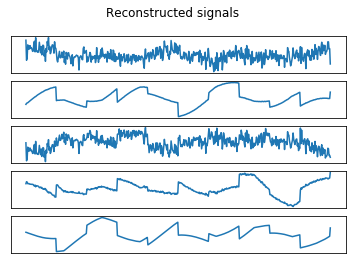

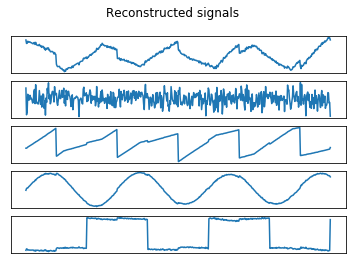

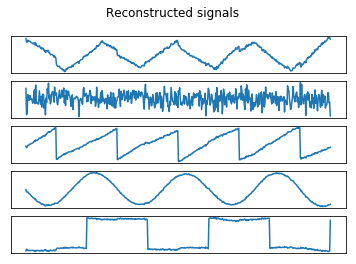

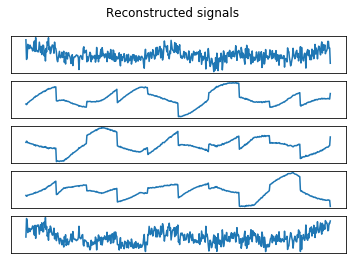

In [46]:
# 1.8 Experiments
for W in W_estimates:
    plot_signals(W@Xw, title="Reconstructed signals")

In [47]:
import time

def does_whitening_make_a_difference():
    '''Evaluates if whitening data makes ICA converge faster.
    
    Returns:
        (bool) True, if whitening makes ICA converge
        faster, False otherwise.
    '''
    # Does it make a difference (in terms of speed of convergence) 
    # if you whiten your data before running ICA?
    
    t_start = time.time()
    W_estimates = [ICA(Xw, activation_function=phi) for phi in activation_functions]
    time_whitening = time.time() - t_start
    print('Time it takes to converges with whitening: %s' % time_whitening)
    
    t_start = time.time()
    W_estimates = [ICA(X, activation_function=phi) for phi in activation_functions]
    time_no_whitening = time.time() - t_start
    print('Time it takes to converge without whitening: %s' % time_no_whitening)
    
    # Return True or False
    # YOUR CODE HERE
    return time_whitening < time_no_whitening

In [48]:
assert type(does_whitening_make_a_difference()) == bool

Converged in 3071 iterations, final weight gradient norm 0.00001
Converged in 1822 iterations, final weight gradient norm 0.00001
Converged in 1697 iterations, final weight gradient norm 0.00001
Converged in 4251 iterations, final weight gradient norm 0.00001
Time it takes to converges with whitening: 1.355567216873169
Converged in 2141 iterations, final weight gradient norm 0.00001
Converged in 1571 iterations, final weight gradient norm 0.00001
Converged in 7 iterations, final weight gradient norm nan


C:\Users\Daan\Miniconda3\envs\ml2labs\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  


Converged in 6902 iterations, final weight gradient norm 0.00001
Time it takes to converge without whitening: 1.0768635272979736


### 1.9 Audio demixing (10 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and plots them.

Use a random non-singular mixing matrix to mix the 5 sound files. You can listen to the results in your browser using `play_signals`, or save them to disk if this does not work for you. Plot histograms of the mixed audio and use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think of ways to deal with these issues.

In [49]:
import scipy.io.wavfile
from IPython.display import Audio, display, Markdown

# Save mixtures to disk, so you can listen to them in your audio player
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)

# Or play them in your browser
def play_signals(S, sample_rate, title="Signals"):
    display(Markdown(title))
    for signal in S:
        display(Audio(signal, rate=sample_rate))

Signals

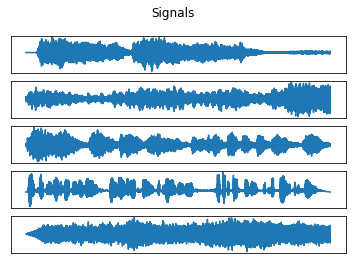

In [50]:
# Load audio sources
source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']
wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert(sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length

# Create source and measurement data
S_audio = np.c_[wav_data]
plot_signals(S_audio)
play_signals(S_audio, sample_rate)

Original signals

Converged in 1088 iterations, final weight gradient norm 0.00001
Not converged.
Converged in 4153 iterations, final weight gradient norm 0.00001
Converged in 919 iterations, final weight gradient norm 0.00001


Best reconstructed signals

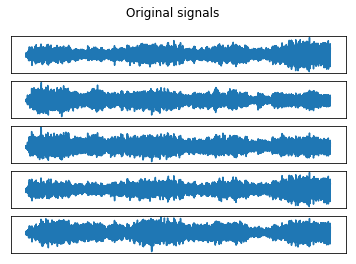

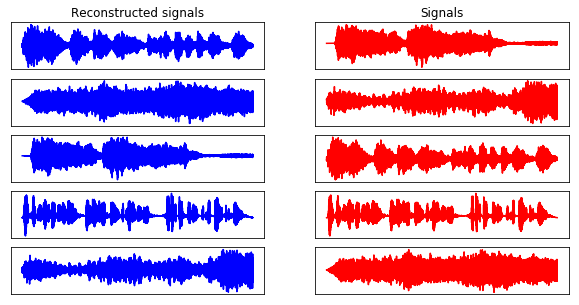

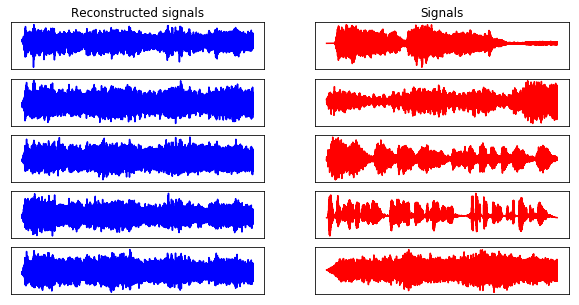

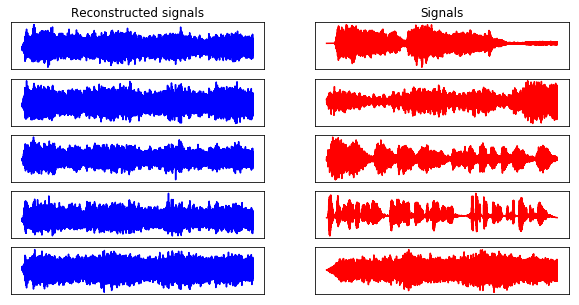

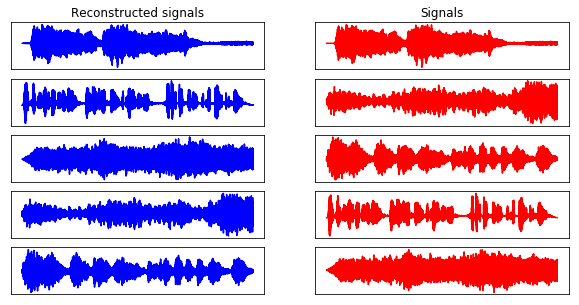

In [70]:
### 1.9 Audio demixing

def plot_2signals(X1, X2, title1="Reconstructed signals", title2='Signals', figsize=(10, 5)):
    """Plot two signals contained in the rows of X1 and X2
    """
    fig = figure(figsize=figsize)
    assert X1.shape == X2.shape
    num_s = X1.shape[0]
    colors = ['blue', 'red']
    index = 0
    for i in range(X1.shape[0]):
        index += 1
        ax = plt.subplot(num_s, 2, index)
        plot(X1[i, :], color=colors[0])
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(title1)
        
        index += 1
        ax = plt.subplot(num_s, 2, index)
        plot(X2[i, :], color=colors[1])
        ax.set_xticks([])
        ax.set_yticks([])
        if i == 0:
            ax.set_title(title2)

# Mix the audio signals
A_audio = random_nonsingular_matrix(d=S_audio.shape[0])
X_audio = make_mixtures(S_audio, A_audio)
plot_signals(X_audio, title="Original signals")
play_signals(X_audio, sample_rate, title="Original signals")

# Demix the audio signals
Xw_audio = whiten(X_audio)
W_audio_est = [ICA(Xw_audio, activation_function=phi) for phi in activation_functions]
for W in W_audio_est:
    plot_2signals(W@Xw_audio, S_audio)


# The best denoising matrices were created with the first and last activation function
W = W_audio_est[3]
play_signals(W@Xw_audio, sample_rate, title="Best reconstructed signals")

Report your results. Using which activation functions ICA recovers the sources?

The best demixing matrices were found with activation functions $\phi_0(a) = -\tanh(a)$ and $\phi_3(a) = -\frac{6a}{a^2 + 5}$. Note: in the last question we have a more detailed explanation, using insights we gained from Kurtosis.

### 1.10 Excess Kurtosis (15 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

#### 1.10.1 (10 points)
First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. You may find it helpful to use an online service such as [Wolfram Alpha](https://www.wolframalpha.com/) or [Integral Calculator](https://www.integral-calculator.com/) to (help you) evaluate the required integrals. Give your answer as both an exact expression as well as a numerical approximation (for example $\frac{\pi}{2} \approx 1.571$).


\begin{align}
    p(a) &= \frac{1}{\pi cosh(a)}\\
    \mu &= 0\\
    \mu_4 &= \int{\frac{(a-\mu)^4}{\pi cosh(a)}da} = \frac{5\pi^4}{16}\\
    \sigma^4 &= \left( \int{\frac{(a-\mu)^2}{\pi cosh(a)}da}\right)^2 = \frac{\pi^4}{16}\\
    Kurt[p(a))] &= \frac{\mu_4}{\sigma^4} - 3 = 5 - 3 = 2\\
\end{align}

$\hspace{1cm}$

\begin{align}
    p(a) &= \frac{cosh(a) \exp\left[-\frac{a^2}{2}]\right]}{-\sqrt{2e\pi}} \\
    \mu &= 0\\
    \mu_4 &= \int{\frac{(a - \mu)^4 cosh(a) \exp\left[-\frac{a^2}{2}]\right]}{-\sqrt{2e\pi}}}da = 10 \\
    \sigma^4 &= \left( 
        \int{\frac{(a - \mu)^2 cosh(a) \exp\left[-\frac{a^2}{2}]\right]}{-\sqrt{2e\pi}}}da 
        \right)^2 = 4\\
    Kurt[p(a))] &= \frac{\mu_4}{\sigma^4} - 3 = \frac{10}{4} - 3 = -\frac{1}{2}\\
\end{align}

$\hspace{1cm}$

\begin{align}
    p(a) &= -\frac{\sqrt{2}\exp\left[-\frac{a^4}{4}\right]}{\Gamma(\frac{1}{4})} \\
    \mu &= 0\\
    \mu_4 &= \int{-(a - \mu)^4\frac{\sqrt{2}\exp\left[-\frac{a^4}{4}\right]}{\Gamma(\frac{1}{4})}}da = 1 \\
    \sigma^4 &= \left( 
        \int{-(a - \mu)^2\frac{\sqrt{2}\exp\left[-\frac{a^4}{4}\right]}{\Gamma(\frac{1}{4})}}da 
        \right)^2 = \frac{4(\Gamma{\frac{3}{4}})^2}{(\Gamma{\frac{1}{4}})^2} \approx 0.456947\\
    Kurt[p(a))] &= \frac{\mu_4}{\sigma^4} - 3 \approx \frac{1}{0.456947} - 3 \approx -0.811562\\
\end{align}

$\hspace{1cm}$

\begin{align}
    p(a) &= -\frac{200\sqrt{5}}{3\pi(a^2 +5)^3}\\
    \mu &= 0\\
    \mu_4 &= \int{-\frac{200\sqrt{5}(a - \mu)^4}{3\pi(a^2 +5)^3}}da = 25 \\
    \sigma^4 &= \left( 
        \int{-\frac{200\sqrt{5}(a - \mu)^2}{3\pi(a^2 +5)^3}}da 
        \right)^2 = \frac{25}{9}\\
    Kurt[p(a))] &= \frac{\mu_4}{\sigma^4} - 3 = \frac{25 \cdot 9}{25} - 3 = 6\\
\end{align}

In [55]:
### Include your answer here (you can use math.gamma if needed)
import math
def get_kurtosis():
    # Return a list with 4 numbers / expressions
    return [2, -0.5, (4*math.gamma(3/4)**2)/math.gamma(1/4)**2, 6]


In [56]:
# Let's check
kurtosis = get_kurtosis()
print (kurtosis)
assert len(kurtosis) == 4


[2, -0.5, 0.45694658104446373, 6]


#### 1.10.2 (5 points)
Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals.

Can you use this data to explain the performance of the various activation functions on the synthetic and real data?

Kurtosis of synthetic data 0: -1.1964024434410994
Kurtosis of synthetic data 1: -1.482871132439309
Kurtosis of synthetic data 2: -1.8401970082696886
Kurtosis of synthetic data 3: -1.2000384006144096
Kurtosis of synthetic data 4: 0.1636455311737106
Kurtosis of real data 0: 1.7943151667734192
Kurtosis of real data 1: 2.0688506407485283
Kurtosis of real data 2: 1.936092953713005
Kurtosis of real data 3: 5.051917206465037
Kurtosis of real data 4: 0.5388758081585339


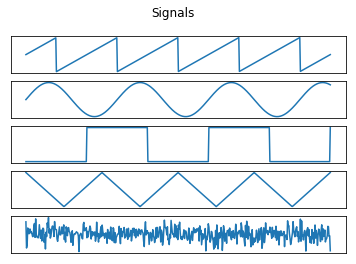

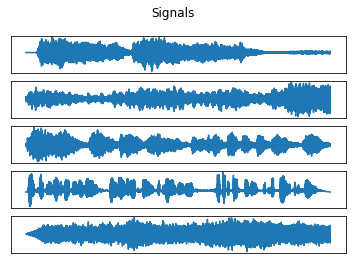

In [57]:
### 1.10.2 Excess Kurtosis
from scipy.stats import kurtosis
for i,s in enumerate(S):
    print('Kurtosis of synthetic data %s: %s' % (i, kurtosis(s, fisher=True)))
plot_signals(S)
for i, s in enumerate(S_audio):
    print('Kurtosis of real data %s: %s' % (i, kurtosis(s, fisher=True)))
plot_signals(S_audio)

First of all, we see that the gaussian-like signals (synthetic noise and street noise) have a Kurtosis close to zero. This is expected: the data is white noise, hence most similar to a Gaussian. And, a 'pure' Gaussian has a Kurtosis of zero. 

Secondly, we note that the synthetic data has negative kurtosis and the real data has positive Kurtosis. This implies that the synthetic data has less weights in the tails of the histograms compared to a Gaussian. Vice versa for the real data. (This is confirmed by looking at the histograms of the synthethic data above and the real data below.) 

We also see that the priors $p_1$ and $p_2$ have negative kurtosis. These priors correspond with the activation functions which were able to most accurately recover the synthetic signals from the measurements, see plot of 1.8. 

While the prios $p_0$ and $p_3$ have positive Kurtosis, which correspond with the activation functions that resulted in a demixing matrix that was able to separate the audio signals. In general, the best choice in prior is a prior that matches the underlying signals the best. Therefore a prior which has negative kurtosis is a good choice if the signals also have negative kurtosis, and vice versa.

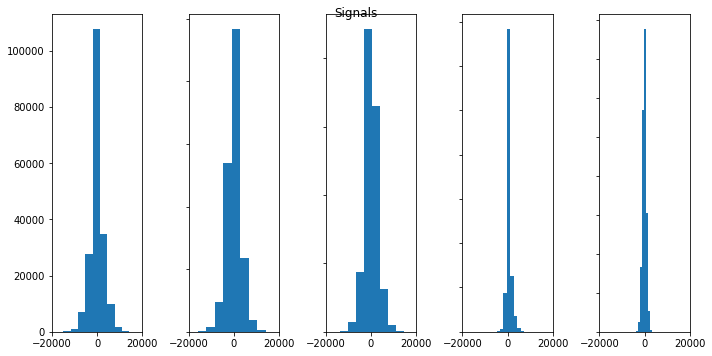

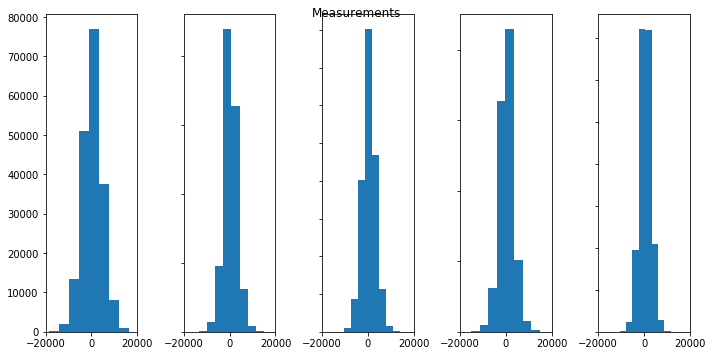

In [67]:
xlim = [-20000, 20000]
fig = plt.figure(4, figsize=(10, 5))
plot_histograms(S_audio, title='Signals', fig=fig, xlim=xlim)
fig = plt.figure(5, figsize=(10, 5))
plot_histograms(X_audio, title='Measurements', fig=fig, xlim=xlim)